In [1]:
import numpy as np
from cart import TreeNode, BinaryDecisionTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from utils import cat_label_convert

In [4]:
### XGBoost定义
class XGBoost:
    def __init__(self, n_estimators=300, learning_rate=0.001, 
                 min_samples_split=2,
                 min_gini_impurity=999, 
                 max_depth=2):
        # 树的棵树
        self.n_estimators = n_estimators
        # 学习率
        self.learning_rate = learning_rate 
        # 结点分裂最小样本数
        self.min_samples_split = min_samples_split 
        # 结点最小基尼不纯度
        self.min_gini_impurity = min_gini_impurity  
        # 树最大深度
        self.max_depth = max_depth                  
        # 用于分类的对数损失
        # 回归任务可定义平方损失 
        # self.loss = SquaresLoss()
        self.loss = LogisticLoss()
        # 初始化分类树列表
        self.trees = []
        # 遍历构造每一棵决策树
        for _ in range(n_estimators):
            tree = XGBoost_Single_Tree(
                    min_samples_split=self.min_samples_split,
                    min_gini_impurity=self.min_gini_impurity,
                    max_depth=self.max_depth,
                    loss=self.loss)
            self.trees.append(tree)
    
    # xgboost拟合方法
    def fit(self, X, y):
        y = cat_label_convert(y) #标签转化为 0 1
        y_pred = np.zeros(np.shape(y))
        # 拟合每一棵树后进行结果累加
        for i in range(self.n_estimators):
            tree = self.trees[i]
            y_true_pred = np.concatenate((y, y_pred), axis=1)
            tree.fit(X, y_true_pred)
            iter_pred = tree.predict(X)
            y_pred -= np.multiply(self.learning_rate, iter_pred)

    # xgboost预测方法
    def predict(self, X):
        y_pred = None
        # 遍历预测
        for tree in self.trees:
            iter_pred = tree.predict(X)
            if y_pred is None:
                y_pred = np.zeros_like(iter_pred)
            y_pred -= np.multiply(self.learning_rate, iter_pred)
        y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
        # 将概率预测转换为标签
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

In [3]:
### 分类损失函数定义
# 定义Sigmoid类
class Sigmoid:
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

# 定义Logit损失
class LogisticLoss:
    def __init__(self):
        sigmoid = Sigmoid()
        self._func = sigmoid
        self._grad = sigmoid.gradient
    
    # 定义损失函数形式
    def loss(self, y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) #裁剪y_pred的值 在1e-15 ～ 1-1e-15之间
        p = self._func(y_pred)
        return y * np.log(p) + (1 - y) * np.log(1 - p)

    # 定义一阶梯度
    def gradient(self, y, y_pred):
        p = self._func(y_pred)
        return -(y - p)

    # 定义二阶梯度
    def hess(self, y, y_pred):
        p = self._func(y_pred)
        return p * (1 - p)

In [2]:
### XGBoost单棵树类
class XGBoost_Single_Tree(BinaryDecisionTree):
    # 结点分裂方法
    def node_split(self, y):
        # 中间特征所在列
        feature = int(np.shape(y)[1]/2)
        # 左子树为真实值，右子树为预测值
        y_true, y_pred = y[:, :feature], y[:, feature:]
        return y_true, y_pred

    # 信息增益计算方法
    def gain(self, y, y_pred):
        # 梯度计算
        Gradient = np.power((y * self.loss.gradient(y, y_pred)).sum(), 2)
        # Hessian矩阵计算
        Hessian = self.loss.hess(y, y_pred).sum()
        return 0.5 * (Gradient / Hessian)

    # 树分裂增益计算
    # 式(12.28)
    def gain_xgb(self, y, y1, y2):
        # 结点分裂
        y_true, y_pred = self.node_split(y)
        y1, y1_pred = self.node_split(y1)
        y2, y2_pred = self.node_split(y2)
        true_gain = self.gain(y1, y1_pred)
        false_gain = self.gain(y2, y2_pred)
        gain = self.gain(y_true, y_pred)
        return true_gain + false_gain - gain

    # 计算叶子结点最优权重
    def leaf_weight(self, y):
        y_true, y_pred = self.node_split(y)
        # 梯度计算
        gradient = np.sum(y_true * self.loss.gradient(y_true, y_pred), axis=0)
        # hessian矩阵计算
        hessian = np.sum(self.loss.hess(y_true, y_pred), axis=0)
        # 叶子结点得分
        leaf_weight =  gradient / hessian
        return leaf_weight

    # 树拟合方法
    def fit(self, X, y):
        self.impurity_calculation = self.gain_xgb
        self._leaf_value_calculation = self.leaf_weight
        super(XGBoost_Single_Tree, self).fit(X, y)

In [5]:
from sklearn import datasets
# 导入鸢尾花数据集
data = datasets.load_iris()
# 获取输入输出
X, y = data.data, data.target
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)  
# 创建xgboost分类器
clf = XGBoost()
# 模型拟合
clf.fit(X_train, y_train)
# 模型预测
y_pred = clf.predict(X_test)
# 准确率评估
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy: ", accuracy)

/Users/heshuaichen/numpy/机器学习—公式推导与代码实现/10—16Ensemble_Learning_监督集成/utils.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_left, X_right])


Accuracy:  0.9333333333333333


/Users/heshuaichen/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[19:54:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9666666666666667


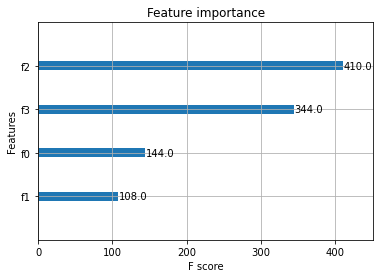

In [7]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt

# 设置模型参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',   
    'num_class': 3,     
    'gamma': 0.1,
    'max_depth': 2,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.001,
    'seed': 1000,
    'nthread': 4,
}


dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 200
model = xgb.train(params, dtrain, num_rounds)
# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy:", accuracy)
# 绘制特征重要性
plot_importance(model)
plt.show();